## Load Data

**Required files in DATA_DIR:**
- `metrics.xlsx`: Excel file with model predictions (columns: `model_name`, `predicts`, `tag`)
- `test_labels.txt`: Text file with true labels (one label per line, 0 or 1)

**Expected format:**
- Each row in Excel = one model run
- `predicts` column = comma-separated probabilities for test samples
- `tag` column = run identifier (same tag = same run across different models)

In [2]:
# Cell 1: Import libraries and load data
import pandas as pd
import numpy as np
import ast
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Set data paths
DATA_DIR = '../data'
excel_path = os.path.join(DATA_DIR, 'metrics.xlsx')
labels_path = os.path.join(DATA_DIR, 'test_labels.txt')

# Load Excel file with model predictions
df_models = pd.read_excel(excel_path)

# Load true labels from test set
with open(labels_path, 'r') as file:
    true_labels = np.array([int(line.strip()) for line in file])

print(f"Loaded {len(df_models)} model results")
print(f"Loaded {len(true_labels)} true labels (test set)")
print(f"Label distribution: {np.sum(true_labels)} positive class, {len(true_labels) - np.sum(true_labels)} negative class")


Loaded 1200 model results
Loaded 46 true labels (test set)
Label distribution: 20 positive (ischemic), 26 negative (non-ischemic)


In [3]:
# Cell 2: Check loaded data
# Display first few rows to verify data loading
print("First 5 rows of model data:")
print(df_models.head())

# Show columns
print("\nColumns in the dataset:")
print(df_models.columns.tolist())

# Show unique models
print("\nUnique models:")
print(df_models['model_name'].unique())

# Check number of runs per model - let's find the column that identifies runs
if 'tag' in df_models.columns:
    runs_per_model = df_models.groupby('model_name')['tag'].nunique()
    print("\nNumber of unique runs per model:")
    print(runs_per_model)
    
    # Check unique run identifiers
    print("\nUnique run identifiers (tags):")
    print(df_models['tag'].unique()[:10])  # Show first 10
else:
    print("\nNo 'tag' column found. Available columns:")
    print(df_models.columns.tolist())
    
    # Try to identify which column might be the run identifier
    for col in df_models.columns:
        if df_models[col].dtype in ['int64', 'int32', 'float64']:
            unique_vals = df_models[col].nunique()
            if unique_vals <= 100:  # Potential run identifier
                print(f"Column '{col}' has {unique_vals} unique values - could be run identifier")
                print(f"First 10 values: {df_models[col].unique()[:10]}")


First 5 rows of model data:
    model_name  elapsed_time  input_size  batch_size  epochs  \
0  DenseNet169     96.582933         128           5     100   
1  DenseNet169    124.820762         128           5     100   
2  DenseNet169     91.146014         128           5     100   
3  DenseNet169     96.192812         128           5     100   
4  DenseNet169    134.586274         128           5     100   

   epochs_partial_1  epochs_partial_2  freeze_fe  is_gray optimizer  ...  \
0               100               100       True    False      Adam  ...   
1               100               100       True    False      Adam  ...   
2               100               100       True    False      Adam  ...   
3               100               100       True    False      Adam  ...   
4               100               100       True    False      Adam  ...   

   test_precision  test_recall  test_f1score  test_confusion_matrix  \
0        0.928571         0.65      0.764706    [[25  1]\n 

## Verify Data Structure
Check that data loaded correctly and inspect required columns

In [4]:
# Cell 3: Define ensemble functions
def parse_predictions(pred_string):
    """Parse the prediction string into a numpy array"""
    try:
        # Handle string representation of predictions
        if isinstance(pred_string, str):
            # Handle different possible formats
            # Remove any brackets, parentheses, and split by comma or space
            cleaned = pred_string.strip('[](){} ')
            # Split by comma first, if not present, split by space
            if ',' in cleaned:
                items = cleaned.split(',')
            else:
                items = cleaned.split()
            
            # Convert to float array
            return np.array([float(x.strip()) for x in items if x.strip()])
        elif isinstance(pred_string, (list, np.ndarray)):
            return np.array(pred_string)
        else:
            print(f"Unexpected type for predictions: {type(pred_string)}")
            return None
    except Exception as e:
        print(f"Error parsing: {pred_string}")
        print(f"Error message: {str(e)}")
        return None

def hard_voting_ensemble(predictions_list):
    """Perform hard voting ensemble"""
    # Convert probabilities to binary predictions
    binary_preds = [np.round(preds) for preds in predictions_list]
    # Stack and calculate majority vote
    stacked = np.vstack(binary_preds)
    return np.round(np.mean(stacked, axis=0))

def soft_voting_ensemble(predictions_list):
    """Perform soft voting ensemble"""
    # Average probabilities
    avg_probs = np.mean(predictions_list, axis=0)
    # Convert to binary predictions
    return np.round(avg_probs)

def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calculate all classification metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'sensitivity': recall_score(y_true, y_pred),  # Same as recall
        'f1_score': f1_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
    }
    
    # Calculate specificity from confusion matrix
    tn, fp, fn, tp = metrics['confusion_matrix'].ravel()
    metrics['specificity'] = tn / (tn + fp)
    
    # Calculate AUC if probability predictions are available
    if y_prob is not None:
        metrics['auc'] = roc_auc_score(y_true, y_prob)
    
    return metrics

def create_ensemble_by_run(model_names, run_number, voting_method='soft'):
    """Create an ensemble from selected models using the same run number (based on order)"""
    predictions = []
    
    for model_name in model_names:
        # Get all runs for this model
        model_data = df_models[df_models['model_name'] == model_name].reset_index(drop=True)
        
        # Check if run_number is within bounds
        if run_number > len(model_data):
            print(f"Warning: Run {run_number} not available for {model_name} (only {len(model_data)} runs)")
            continue
        
        # Get the specific run (0-indexed, so subtract 1)
        specific_run = model_data.iloc[run_number - 1]
        
        # Parse predictions
        preds = parse_predictions(specific_run['predicts'])
        if preds is not None:
            # Ensure we only use the first 46 predictions (test set size)
            preds = preds[:46]
            predictions.append(preds)
    
    if not predictions:
        raise ValueError(f"No valid predictions found for run {run_number}")
    
    # Perform ensemble voting
    if voting_method == 'hard':
        ensemble_pred = hard_voting_ensemble(predictions)
        ensemble_prob = None
    else:  # soft voting
        ensemble_prob = np.mean(predictions, axis=0)
        ensemble_pred = np.round(ensemble_prob)
    
    return ensemble_pred, ensemble_prob


In [5]:
# Cell 4: Create multiple ensembles (one per run)



# Configuration: Choose models for the ensemble
# Replace these with model names from the 'model_name' column in the Excel file
models_to_use = ['InceptionResNetV2', 'DenseNet201', 'Xception']

# Voting method: 'hard' or 'soft'
voting_method = 'hard'

# Create ensembles for all runs
num_runs = 100  # Adjust if needed
ensemble_results = []

for run_num in range(1, num_runs + 1):
    try:
        ensemble_pred, ensemble_prob = create_ensemble_by_run(models_to_use, run_num, voting_method)
        metrics = calculate_metrics(true_labels, ensemble_pred, ensemble_prob)
        
        result = {
            'run_number': run_num,
            'predictions': ensemble_pred,
            'probabilities': ensemble_prob,
            'metrics': metrics
        }
        ensemble_results.append(result)
    except Exception as e:
        print(f"Error creating ensemble for run {run_num}: {str(e)}")

# Display median metrics across all runs
if ensemble_results:
    median_metrics = {
        'accuracy': np.median([r['metrics']['accuracy'] for r in ensemble_results]),
        'precision': np.median([r['metrics']['precision'] for r in ensemble_results]),
        'recall': np.median([r['metrics']['recall'] for r in ensemble_results]),
        'specificity': np.median([r['metrics']['specificity'] for r in ensemble_results]),
        'f1_score': np.median([r['metrics']['f1_score'] for r in ensemble_results]),
        'auc': np.median([r['metrics']['auc'] for r in ensemble_results if 'auc' in r['metrics']])
    }
    
    ensemble_name = f"{voting_method}_" + "_".join(models_to_use)
    print(f"\nEnsemble: {ensemble_name}")
    print(f"Median metrics across {len(ensemble_results)} runs:")
    print("-" * 50)
    print(f"Accuracy: {median_metrics['accuracy']:.4f}")
    print(f"Precision: {median_metrics['precision']:.4f}")
    print(f"Recall/Sensitivity: {median_metrics['recall']:.4f}")
    print(f"Specificity: {median_metrics['specificity']:.4f}")
    print(f"F1-Score: {median_metrics['f1_score']:.4f}")
    print(f"AUC: {median_metrics['auc']:.4f}")


Ensemble: hard_InceptionResNetV2_DenseNet201_Xception
Median metrics across 100 runs:
--------------------------------------------------
Accuracy: 0.8478
Precision: 0.9333
Recall/Sensitivity: 0.7000
Specificity: 0.9615
F1-Score: 0.8000
AUC: nan


/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Define Ensemble Functions
Functions for hard voting (majority vote) and soft voting (average probabilities)

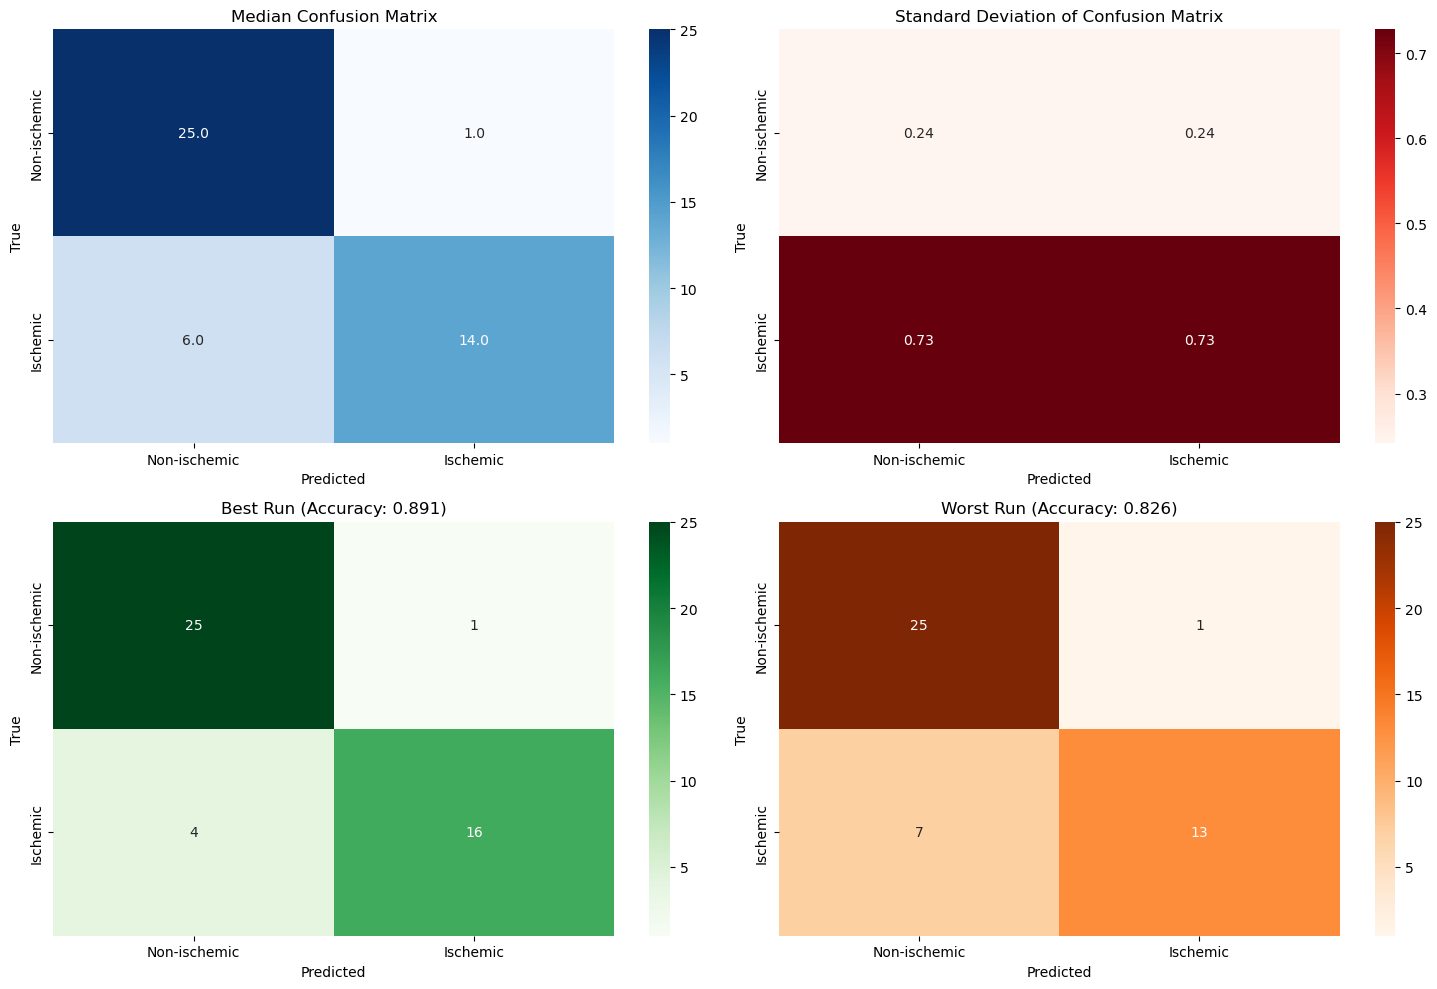


Confusion Matrix Analysis:
----------------------------------------
Median True Negatives: 25.0
Median False Positives: 1.0
Median False Negatives: 6.0
Median True Positives: 14.0

Median False Positive Rate: 0.038
Median False Negative Rate: 0.300

Most Inconsistent Predictions:
----------------------------------------
   image  true_label  consistency  pred_0_count  pred_1_count
7      8           1         0.73            27            73


In [6]:
# Cell 4.5: Confusion Matrix Analysis
def analyze_confusion_matrices(ensemble_results):
    """Analyze confusion matrices across all ensemble runs"""
    
    # Extract all confusion matrices
    cms = [result['metrics']['confusion_matrix'] for result in ensemble_results]
    
    # Calculate median confusion matrix
    median_cm = np.median(cms, axis=0)
    
    # Calculate confusion matrix statistics
    cm_stats = {
        'median': median_cm,
        'std': np.std(cms, axis=0),
        'min': np.min(cms, axis=0),
        'max': np.max(cms, axis=0)
    }
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot median confusion matrix
    sns.heatmap(median_cm, annot=True, fmt='.1f', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Median Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('True')
    axes[0, 0].set_xticklabels(['Non-ischemic', 'Ischemic'])
    axes[0, 0].set_yticklabels(['Non-ischemic', 'Ischemic'])
    
    # Plot standard deviation of confusion matrix
    sns.heatmap(cm_stats['std'], annot=True, fmt='.2f', cmap='Reds', ax=axes[0, 1])
    axes[0, 1].set_title('Standard Deviation of Confusion Matrix')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('True')
    axes[0, 1].set_xticklabels(['Non-ischemic', 'Ischemic'])
    axes[0, 1].set_yticklabels(['Non-ischemic', 'Ischemic'])
    
    # Plot confusion matrix from best run (highest accuracy)
    best_run = max(ensemble_results, key=lambda x: x['metrics']['accuracy'])
    sns.heatmap(best_run['metrics']['confusion_matrix'], annot=True, fmt='d', cmap='Greens', ax=axes[1, 0])
    axes[1, 0].set_title(f'Best Run (Accuracy: {best_run["metrics"]["accuracy"]:.3f})')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('True')
    axes[1, 0].set_xticklabels(['Non-ischemic', 'Ischemic'])
    axes[1, 0].set_yticklabels(['Non-ischemic', 'Ischemic'])
    
    # Plot confusion matrix from worst run (lowest accuracy)
    worst_run = min(ensemble_results, key=lambda x: x['metrics']['accuracy'])
    sns.heatmap(worst_run['metrics']['confusion_matrix'], annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1])
    axes[1, 1].set_title(f'Worst Run (Accuracy: {worst_run["metrics"]["accuracy"]:.3f})')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('True')
    axes[1, 1].set_xticklabels(['Non-ischemic', 'Ischemic'])
    axes[1, 1].set_yticklabels(['Non-ischemic', 'Ischemic'])
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display key metrics from confusion matrix
    median_tn, median_fp, median_fn, median_tp = median_cm.ravel()
    
    print("\nConfusion Matrix Analysis:")
    print("-" * 40)
    print(f"Median True Negatives: {median_tn:.1f}")
    print(f"Median False Positives: {median_fp:.1f}")
    print(f"Median False Negatives: {median_fn:.1f}")
    print(f"Median True Positives: {median_tp:.1f}")
    print()
    print(f"Median False Positive Rate: {median_fp / (median_fp + median_tn):.3f}")
    print(f"Median False Negative Rate: {median_fn / (median_fn + median_tp):.3f}")
    
    # Analyze consistency of predictions
    prediction_consistency = []
    for img_idx in range(len(true_labels)):
        predictions_for_image = [r['predictions'][img_idx] for r in ensemble_results]
        consistency = np.mean(predictions_for_image)
        prediction_consistency.append({
            'image': img_idx + 1,
            'true_label': true_labels[img_idx],
            'consistency': consistency,
            'pred_0_count': predictions_for_image.count(0),
            'pred_1_count': predictions_for_image.count(1)
        })
    
    consistency_df = pd.DataFrame(prediction_consistency)
    
    # Show images with most inconsistent predictions
    print("\nMost Inconsistent Predictions:")
    print("-" * 40)
    inconsistent = consistency_df[
        (consistency_df['consistency'] >= 0.2) & 
        (consistency_df['consistency'] <= 0.8)
    ].sort_values('consistency')
    
    if len(inconsistent) > 0:
        print(inconsistent)
    else:
        print("All predictions are highly consistent across runs.")
    
    return cm_stats, consistency_df

# Run the confusion matrix analysis
cm_stats, consistency_df = analyze_confusion_matrices(ensemble_results)

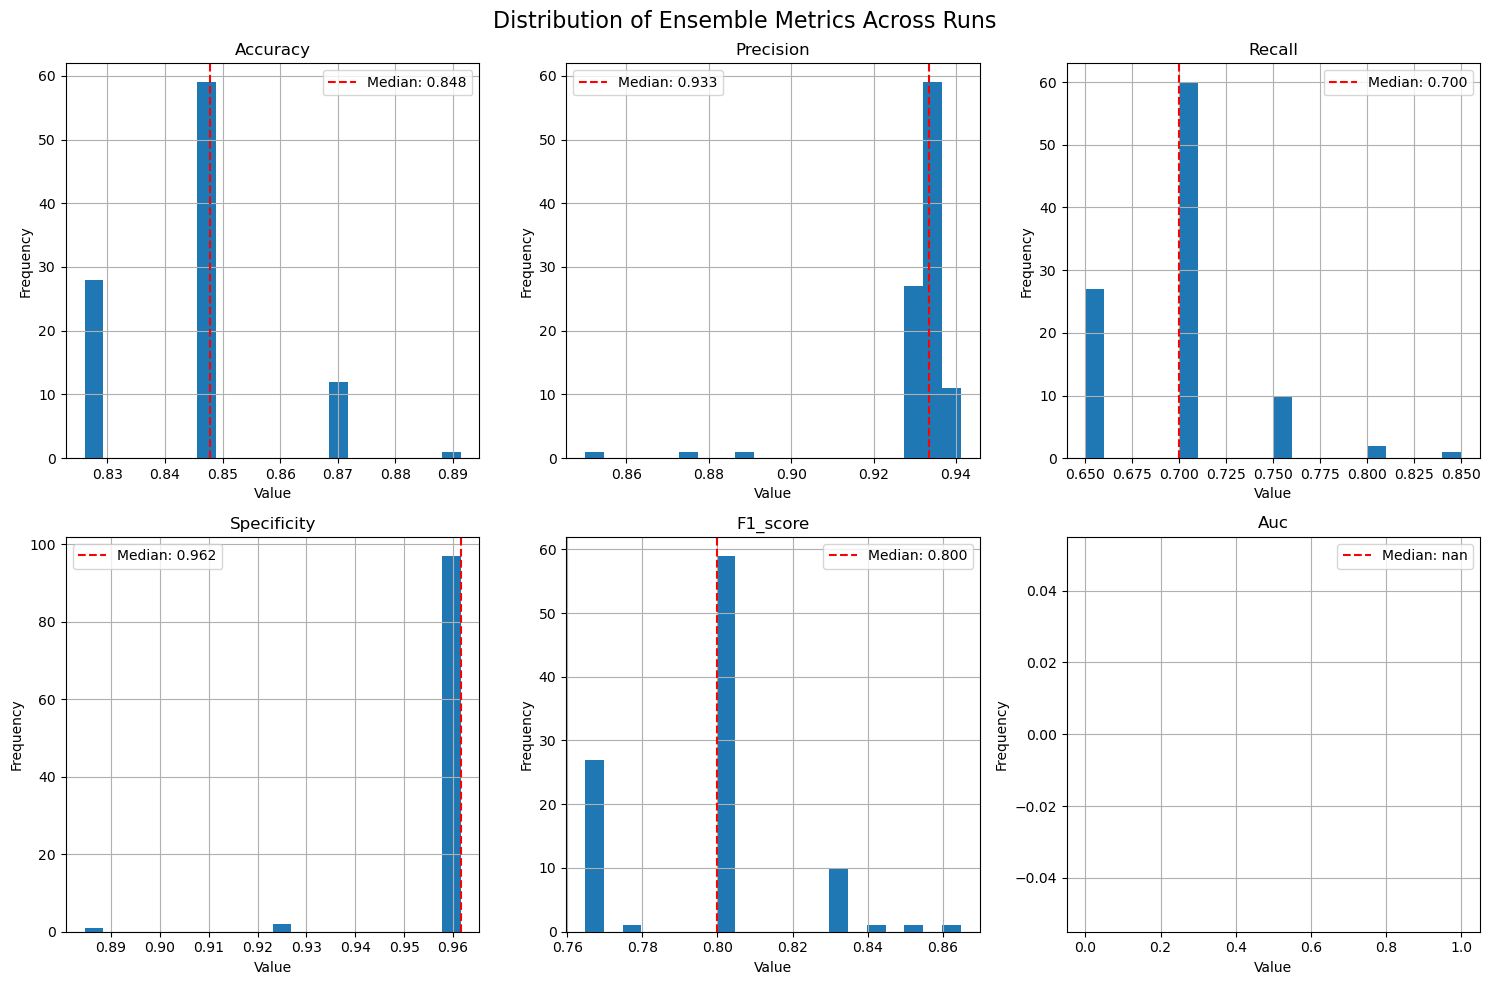

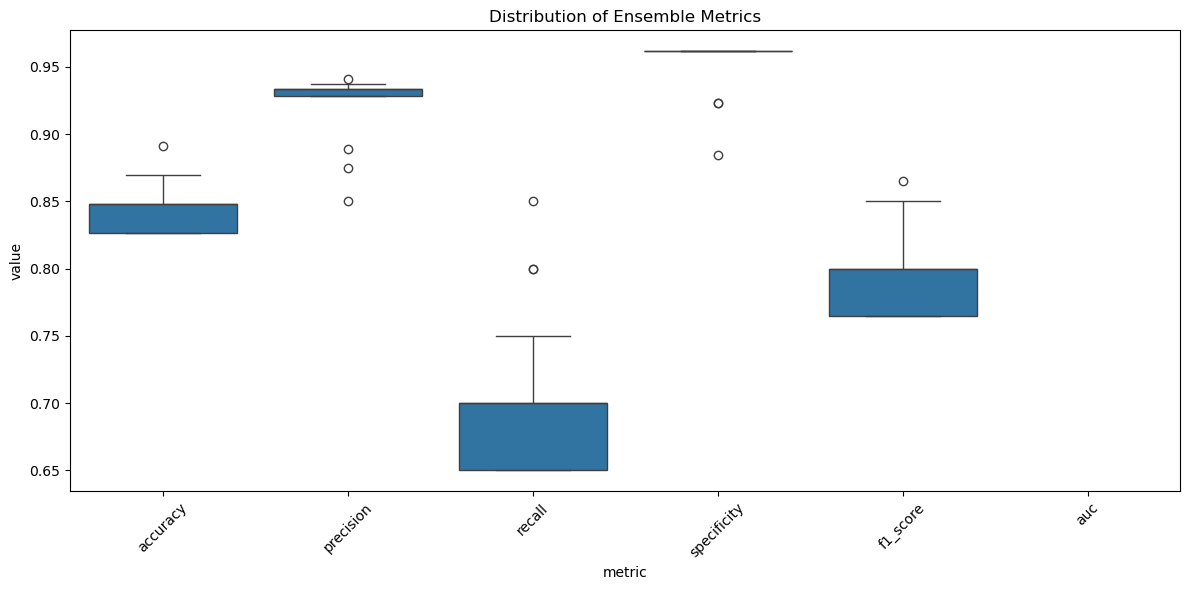

In [7]:
# Cell 5: Analyze ensemble performance distribution
def plot_ensemble_metrics_distribution(ensemble_results):
    """Plot distribution of metrics across all ensemble runs"""
    metrics_df = pd.DataFrame([{
        'run': r['run_number'],
        'accuracy': r['metrics']['accuracy'],
        'precision': r['metrics']['precision'],
        'recall': r['metrics']['recall'],
        'specificity': r['metrics']['specificity'],
        'f1_score': r['metrics']['f1_score'],
        'auc': r['metrics']['auc'] if 'auc' in r['metrics'] else np.nan
    } for r in ensemble_results])
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Distribution of Ensemble Metrics Across Runs', fontsize=16)
    
    metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        metrics_df[metric].hist(ax=ax, bins=20)
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        
        # Add median line
        median_val = metrics_df[metric].median()
        ax.axvline(median_val, color='red', linestyle='--', 
                  label=f'Median: {median_val:.3f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Box plot of all metrics
    plt.figure(figsize=(12, 6))
    metrics_long = metrics_df.melt(id_vars=['run'], var_name='metric', value_name='value')
    sns.boxplot(data=metrics_long, x='metric', y='value')
    plt.title('Distribution of Ensemble Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_ensemble_metrics_distribution(ensemble_results)


## Build Ensembles

**What this does:**
- Combines predictions from multiple models using voting
- Creates one ensemble per run (matching models by `tag`)
- Calculates metrics for each ensemble

**To use:** Set `models_to_use` to the model names from the Excel file

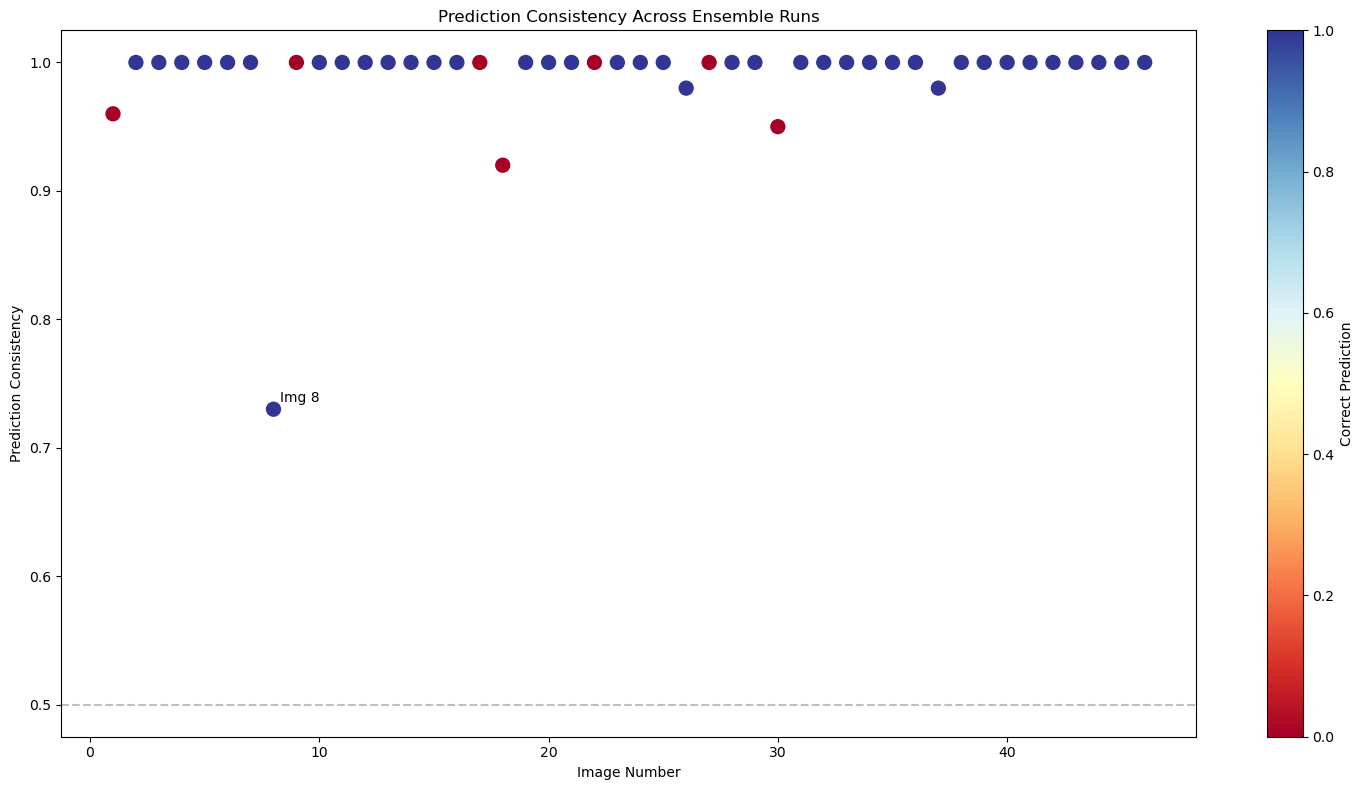


Images with highest uncertainty (lowest consistency):
    image_number  true_label  consistency  pred_0_count  pred_1_count  correct
7              8           1         0.73            27            73     True
17            18           1         0.92            92             8    False
29            30           1         0.95            95             5    False
0              1           1         0.96            96             4    False
36            37           0         0.98            98             2     True
25            26           0         0.98            98             2     True
26            27           1         1.00           100             0    False
27            28           0         1.00           100             0     True
28            29           1         1.00             0           100     True
30            31           1         1.00             0           100     True


In [8]:
# Cell 6: Analyze prediction consistency across runs
def analyze_prediction_consistency(ensemble_results):
    """Analyze how consistent predictions are across different runs"""
    # Stack all predictions
    all_predictions = np.vstack([r['predictions'] for r in ensemble_results])
    
    # Calculate statistics per image
    prediction_stats = []
    for img_idx in range(len(true_labels)):
        img_preds = all_predictions[:, img_idx]
        
        stats = {
            'image_number': img_idx + 1,
            'true_label': true_labels[img_idx],
            'mean_prediction': np.mean(img_preds),
            'std_prediction': np.std(img_preds),
            'pred_0_count': np.sum(img_preds == 0),
            'pred_1_count': np.sum(img_preds == 1),
            'majority_prediction': int(np.mean(img_preds) >= 0.5),
            'consistency': np.max([np.sum(img_preds == 0), np.sum(img_preds == 1)]) / len(img_preds)
        }
        stats['correct'] = stats['majority_prediction'] == stats['true_label']
        prediction_stats.append(stats)
    
    stats_df = pd.DataFrame(prediction_stats)
    
    # Visualize prediction consistency
    plt.figure(figsize=(15, 8))
    plt.scatter(stats_df['image_number'], stats_df['consistency'], 
               c=stats_df['correct'], cmap='RdYlBu', s=100)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Image Number')
    plt.ylabel('Prediction Consistency')
    plt.title('Prediction Consistency Across Ensemble Runs')
    plt.colorbar(label='Correct Prediction')
    
    # Add annotations for inconsistent predictions
    inconsistent = stats_df[stats_df['consistency'] < 0.8]
    for _, row in inconsistent.iterrows():
        plt.annotate(f"Img {int(row['image_number'])}", 
                    (row['image_number'], row['consistency']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

prediction_stats = analyze_prediction_consistency(ensemble_results)

# Show images with highest uncertainty
print("\nImages with highest uncertainty (lowest consistency):")
print(prediction_stats.sort_values('consistency').head(10)[
    ['image_number', 'true_label', 'consistency', 'pred_0_count', 'pred_1_count', 'correct']])

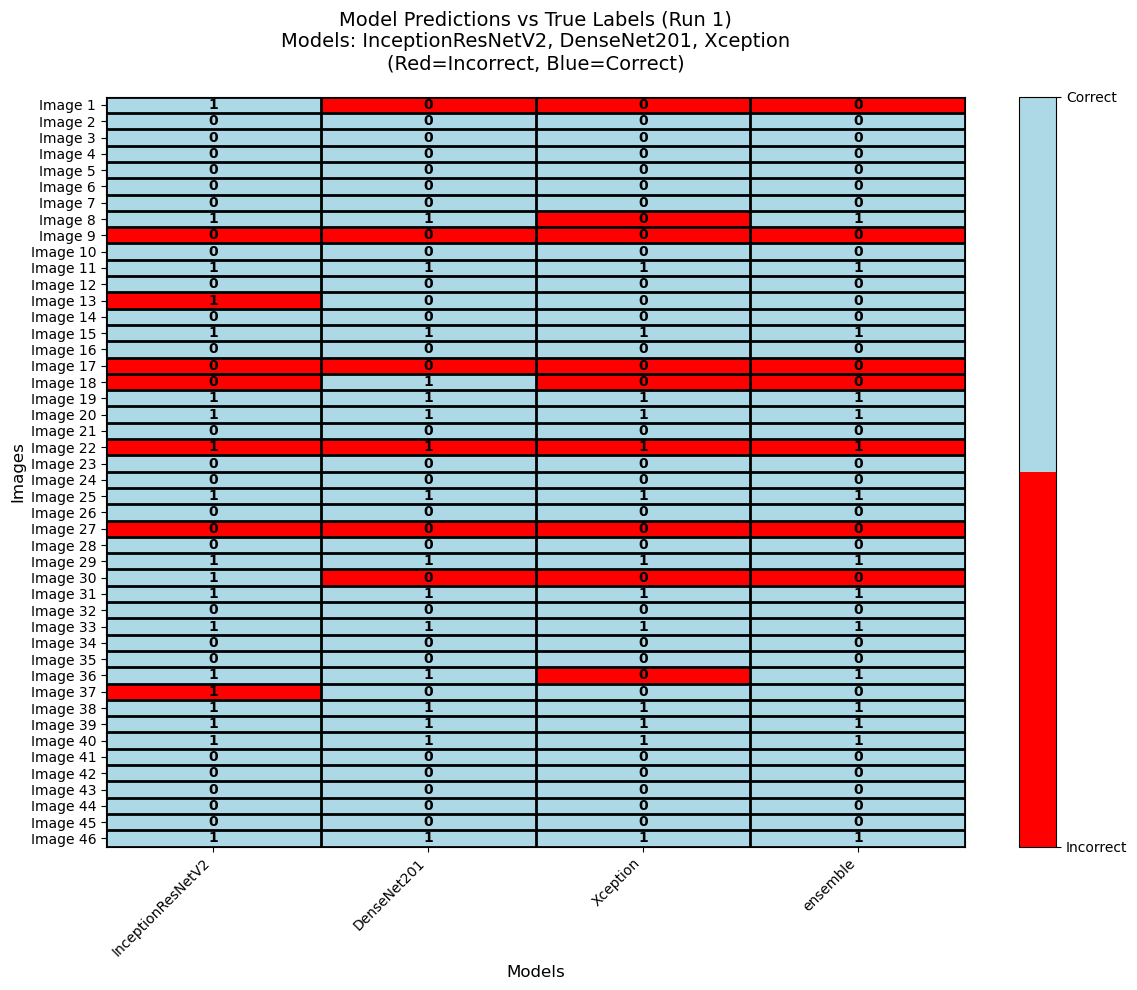

In [9]:
# Cell 7: Create heatmap for a specific run
def create_vote_heatmap_for_run(model_names, run_number, voting_method='soft'):
    """Create a heatmap showing model predictions for a specific run"""
    vote_details = []
    
    for model_name in model_names:
        # Get model data for specific run
        model_data = df_models[(df_models['model_name'] == model_name) & 
                              (df_models['tag'] == run_number)]
        
        if len(model_data) == 0:
            continue
        
        preds = parse_predictions(model_data.iloc[0]['predicts'])
        
        if preds is not None:
            preds = preds[:46]
            vote_details.append({
                'model': model_name,
                'predictions': preds,
                'binary_predictions': np.round(preds)
            })
    
    # Create ensemble prediction for this run
    ensemble_pred, ensemble_prob = create_ensemble_by_run(model_names, run_number, voting_method)
    
    # Create visualization data
    vote_data = []
    for img_idx in range(len(true_labels)):
        img_result = {'image_number': img_idx + 1, 'true_label': true_labels[img_idx]}
        for detail in vote_details:
            img_result[f"{detail['model']}_vote"] = detail['binary_predictions'][img_idx]
        img_result['ensemble_prediction'] = ensemble_pred[img_idx]
        vote_data.append(img_result)
    
    vote_df = pd.DataFrame(vote_data)
    
    # Create heatmap
    vote_cols = [f"{model}_vote" for model in model_names] + ['ensemble_prediction']
    heatmap_data = vote_df[['image_number', 'true_label'] + vote_cols].copy()
    
    # Create correctness array
    correctness_data = np.zeros((len(heatmap_data), len(vote_cols)))
    for i, row in heatmap_data.iterrows():
        for j, col in enumerate(vote_cols):
            correctness_data[i, j] = 1 if row[col] == row['true_label'] else -1
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = plt.cm.colors.ListedColormap(['red', 'lightblue'])
    im = ax.imshow(correctness_data, cmap=cmap, aspect='auto')
    
    # Set labels
    ax.set_xticks(np.arange(len(vote_cols)))
    ax.set_yticks(np.arange(len(heatmap_data)))
    ax.set_xticklabels([col.replace('_vote', '').replace('_prediction', '') for col in vote_cols], 
                      rotation=45, ha='right')
    ax.set_yticklabels([f"Image {i+1}" for i in range(len(heatmap_data))])
    
    # Add grid
    ax.set_xticks(np.arange(len(vote_cols)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(heatmap_data)+1)-.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', size=0)
    
    # Add annotations
    for i in range(len(heatmap_data)):
        for j in range(len(vote_cols)):
            pred_value = int(heatmap_data.iloc[i][vote_cols[j]])
            ax.text(j, i, pred_value, ha="center", va="center", color="black", fontweight='bold')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, ticks=[-1, 1])
    cbar.ax.set_yticklabels(['Incorrect', 'Correct'])
    
    # Set title
    title = f'Model Predictions vs True Labels (Run {run_number})\n'
    title += f'Models: {", ".join(model_names)}\n(Red=Incorrect, Blue=Correct)'
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Images', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Show heatmap for a specific run
run_to_visualize = 1  # Change this to visualize different runs
create_vote_heatmap_for_run(models_to_use, run_to_visualize, voting_method)


Comparison of Ensemble Methods:
        Metric  Averaging Method  Run-by-Run Method
0     Accuracy            0.8478             0.8478
1    Precision            0.9333             0.9333
2       Recall            0.7000             0.7000
3  Specificity            0.9615             0.9615
4     F1-Score            0.8000             0.8000
5          AUC               NaN                NaN


/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


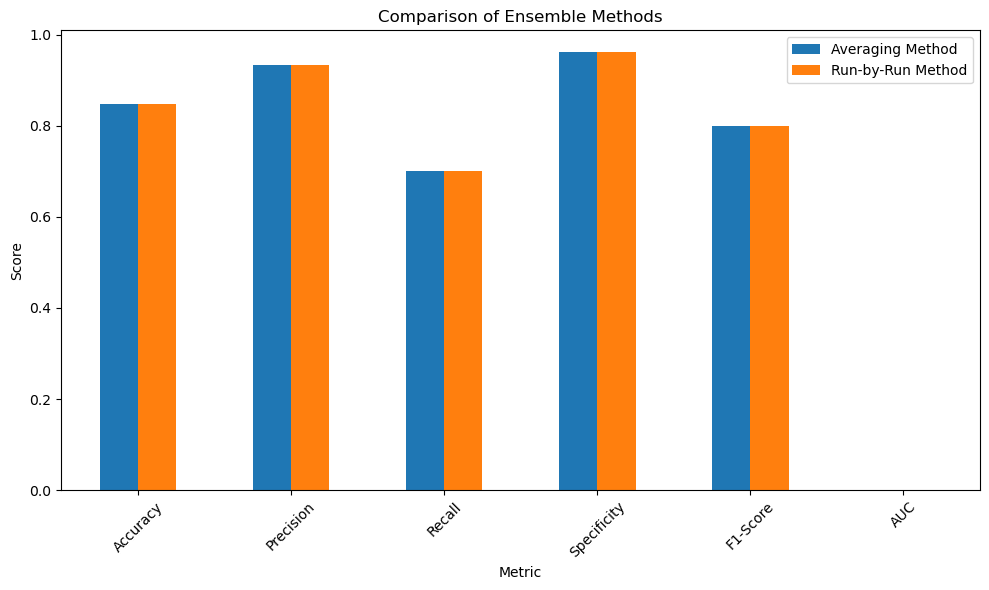

In [10]:
# Cell 8: Compare ensemble methods (average vs run-by-run)
def compare_ensemble_methods(model_names, voting_method='soft'):
    """Compare the original averaging method vs the run-by-run method"""
    # Original averaging method (as in previous version)
    def create_ensemble_average(model_names, voting_method='soft'):
        predictions = []
        
        for model_name in model_names:
            # Get all runs for this model
            model_data = df_models[df_models['model_name'] == model_name]
            
            # Parse predictions
            model_predictions = []
            for idx, row in model_data.iterrows():
                preds = parse_predictions(row['predicts'])
                if preds is not None:
                    preds = preds[:46]
                    model_predictions.append(preds)
            
            if model_predictions:
                # Average predictions across runs for this model
                avg_model_preds = np.mean(model_predictions, axis=0)
                predictions.append(avg_model_preds)
        
        if not predictions:
            raise ValueError("No valid predictions found")
        
        # Perform ensemble voting
        if voting_method == 'hard':
            ensemble_pred = hard_voting_ensemble(predictions)
            ensemble_prob = None
        else:  # soft voting
            ensemble_prob = np.mean(predictions, axis=0)
            ensemble_pred = np.round(ensemble_prob)
        
        return ensemble_pred, ensemble_prob
    
    # Get results from averaging method
    avg_ensemble_pred, avg_ensemble_prob = create_ensemble_average(model_names, voting_method)
    avg_metrics = calculate_metrics(true_labels, avg_ensemble_pred, avg_ensemble_prob)
    
    # Get results from run-by-run method (already computed)
    run_metrics = {
        'accuracy': np.median([r['metrics']['accuracy'] for r in ensemble_results]),
        'precision': np.median([r['metrics']['precision'] for r in ensemble_results]),
        'recall': np.median([r['metrics']['recall'] for r in ensemble_results]),
        'specificity': np.median([r['metrics']['specificity'] for r in ensemble_results]),
        'f1_score': np.median([r['metrics']['f1_score'] for r in ensemble_results]),
        'auc': np.median([r['metrics']['auc'] for r in ensemble_results if 'auc' in r['metrics']])
    }
    
    # Compare results
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'AUC'],
        'Averaging Method': [avg_metrics['accuracy'], avg_metrics['precision'], 
                           avg_metrics['recall'], avg_metrics['specificity'], 
                           avg_metrics['f1_score'], avg_metrics.get('auc', np.nan)],
        'Run-by-Run Method': [run_metrics['accuracy'], run_metrics['precision'], 
                             run_metrics['recall'], run_metrics['specificity'], 
                             run_metrics['f1_score'], run_metrics['auc']]
    })
    
    print("\nComparison of Ensemble Methods:")
    print(comparison_df.round(4))
    
    # Visualize comparison
    comparison_df.plot(x='Metric', y=['Averaging Method', 'Run-by-Run Method'], 
                      kind='bar', figsize=(10, 6))
    plt.title('Comparison of Ensemble Methods')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

compare_ensemble_methods(models_to_use, voting_method)

In [11]:
# Cell 9: Compare Different Model Combinations and Voting Strategies
def weighted_soft_voting_ensemble(predictions_list, weights):
    """Perform weighted soft voting ensemble"""
    # Ensure weights sum to 1
    weights = np.array(weights) / np.sum(weights)
    
    # Weighted average probabilities
    weighted_probs = np.average(predictions_list, axis=0, weights=weights)
    
    # Convert to binary predictions
    return np.round(weighted_probs), weighted_probs

def create_ensemble_with_strategy(model_names, run_number, voting_method='soft', weight_type=None):
    """Create an ensemble with different voting strategies"""
    predictions = []
    weights = []
    
    # Get individual model performance metrics if needed for weighting
    if weight_type:
        model_metrics = []
        for model_name in model_names:
            model_data = df_models[df_models['model_name'] == model_name]
            if weight_type == 'auc':
                # Extract AUC from test metrics - need to calculate from ROC curve
                all_aucs = []
                for idx, row in model_data.iterrows():
                    try:
                        fpr = np.array(ast.literal_eval(row['roc_curve_fpr']))
                        tpr = np.array(ast.literal_eval(row['roc_curve_tpr']))
                        auc = np.trapz(tpr, fpr)
                        all_aucs.append(auc)
                    except:
                        pass
                metric_value = np.median(all_aucs) if all_aucs else 0.5
            elif weight_type == 'sensitivity':
                metric_value = model_data['test_recall'].median()
            model_metrics.append(metric_value)
        
        weights = model_metrics
    
    # Get predictions for each model
    for model_name in model_names:
        model_data = df_models[df_models['model_name'] == model_name].reset_index(drop=True)
        
        if run_number > len(model_data):
            continue
        
        specific_run = model_data.iloc[run_number - 1]
        preds = parse_predictions(specific_run['predicts'])
        
        if preds is not None:
            preds = preds[:46]
            predictions.append(preds)
    
    if not predictions:
        raise ValueError(f"No valid predictions found for run {run_number}")
    
    # Perform voting based on method
    if voting_method == 'hard':
        ensemble_pred = hard_voting_ensemble(predictions)
        ensemble_prob = None
    elif voting_method == 'soft':
        ensemble_prob = np.mean(predictions, axis=0)
        ensemble_pred = np.round(ensemble_prob)
    elif voting_method == 'weighted' and weights:
        ensemble_pred, ensemble_prob = weighted_soft_voting_ensemble(predictions, weights)
    else:
        raise ValueError(f"Invalid voting method: {voting_method}")
    
    return ensemble_pred, ensemble_prob

# Define model combinations to test
# Replace these with the model names from the Excel file
# Typically: select top-performing models based on validation accuracy
top_3_models = ['Xception', 'InceptionResNetV2', 'DenseNet201']
top_5_models = ['VGG19', 'InceptionResNetV2', 'DenseNet201', 'Xception', 'MobileNetV2']

# Define voting strategies
voting_strategies = [
    {'method': 'hard', 'weight_type': None, 'name': 'Hard Voting'},
    {'method': 'soft', 'weight_type': None, 'name': 'Soft Voting'},
    {'method': 'weighted', 'weight_type': 'auc', 'name': 'Weighted Voting (AUC)'},
    {'method': 'weighted', 'weight_type': 'sensitivity', 'name': 'Weighted Voting (Sensitivity)'}
]

# Run ensemble comparison
ensemble_comparison_results = []

for model_set_name, model_set in [('Top-3', top_3_models), ('Top-5', top_5_models)]:
    for strategy in voting_strategies:
        # Run ensemble for all 100 runs
        strategy_results = []
        
        for run_num in range(1, 101):
            try:
                ensemble_pred, ensemble_prob = create_ensemble_with_strategy(
                    model_set, run_num, 
                    voting_method=strategy['method'],
                    weight_type=strategy['weight_type']
                )
                metrics = calculate_metrics(true_labels, ensemble_pred, ensemble_prob)
                strategy_results.append(metrics)
            except Exception as e:
                continue
        
        if strategy_results:
            # Calculate median metrics
            median_metrics = {
                'accuracy': np.median([r['accuracy'] for r in strategy_results]),
                'precision': np.median([r['precision'] for r in strategy_results]),
                'recall': np.median([r['recall'] for r in strategy_results]),
                'specificity': np.median([r['specificity'] for r in strategy_results]),
                'f1_score': np.median([r['f1_score'] for r in strategy_results]),
                'auc': np.median([r['auc'] for r in strategy_results if 'auc' in r])
            }
            
            ensemble_comparison_results.append({
                'model_set': model_set_name,
                'strategy': strategy['name'],
                'metrics': median_metrics
            })


/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/TL2024/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Cell 10: Display Comparison Results
# Create comparison table
comparison_data = []
for result in ensemble_comparison_results:
    row = {
        'Model Set': result['model_set'],
        'Voting Strategy': result['strategy'],
        'Accuracy': result['metrics']['accuracy'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'Specificity': result['metrics']['specificity'],
        'F1-Score': result['metrics']['f1_score'],
        'AUC': result['metrics']['auc']
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\nEnsemble Strategy Comparison:")
print(comparison_df.round(4))


Ensemble Strategy Comparison:
  Model Set                Voting Strategy  Accuracy  Precision  Recall  \
0     Top-3                    Hard Voting    0.8478     0.9333    0.70   
1     Top-3                    Soft Voting    0.8261     0.9286    0.65   
2     Top-3          Weighted Voting (AUC)    0.8261     0.9286    0.65   
3     Top-3  Weighted Voting (Sensitivity)    0.8261     0.9286    0.65   
4     Top-5                    Hard Voting    0.8261     0.9286    0.65   
5     Top-5                    Soft Voting    0.8261     0.9286    0.65   
6     Top-5          Weighted Voting (AUC)    0.8261     0.9286    0.65   
7     Top-5  Weighted Voting (Sensitivity)    0.8261     0.9286    0.65   

   Specificity  F1-Score     AUC  
0       0.9615    0.8000     NaN  
1       0.9615    0.7647  0.8885  
2       0.9615    0.7647  0.8885  
3       0.9615    0.7647  0.8885  
4       0.9615    0.7647     NaN  
5       0.9615    0.7647  0.8712  
6       0.9615    0.7647  0.8702  
7       0.961

In [13]:
!pip install statsmodels



Statistical Testing Results - Comparing Top-3 - Hard Voting against other methods:
                                          Comparison  Wilcoxon_Accuracy_p  \
0         Top-3 - Hard Voting vs Top-3 - Soft Voting             0.000000   
1  Top-3 - Hard Voting vs Top-3 - Weighted Voting...             0.000000   
2  Top-3 - Hard Voting vs Top-3 - Weighted Voting...             0.000000   
3         Top-3 - Hard Voting vs Top-5 - Hard Voting             0.000000   
4         Top-3 - Hard Voting vs Top-5 - Soft Voting             0.000000   
5  Top-3 - Hard Voting vs Top-5 - Weighted Voting...             0.000000   
6  Top-3 - Hard Voting vs Top-5 - Weighted Voting...             0.000000   

   Wilcoxon_F1_p  Wilcoxon_AUC_p  T-test_Accuracy_p  T-test_F1_p  \
0       0.000000             NaN           0.000000     0.000000   
1       0.000000             NaN           0.000000     0.000000   
2       0.000000             NaN           0.000000     0.000000   
3       0.000000           

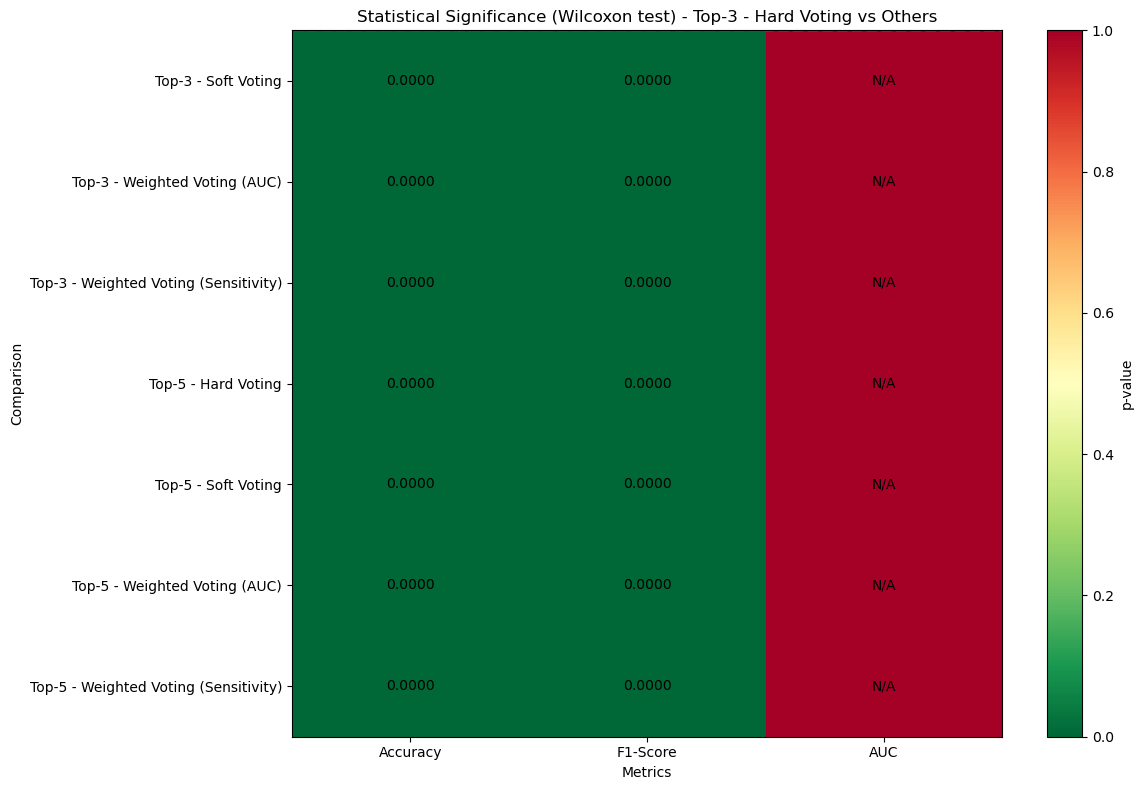

In [14]:
# Cell 10.5: Statistical Testing for Ensemble Comparison
from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

def statistical_testing(ensemble_comparison_results, true_labels):
    """Perform statistical tests to compare the best method against others"""
    
    # First, collect all predictions and metrics for each configuration
    config_results = {}
    
    # Rerun to collect all individual predictions
    for model_set_name, model_set in [('Top-3', top_3_models), ('Top-5', top_5_models)]:
        for strategy in voting_strategies:
            config_name = f"{model_set_name} - {strategy['name']}"
            config_results[config_name] = {
                'predictions': [],
                'accuracies': [],
                'f1_scores': [],
                'aucs': []
            }
            
            # Collect results for all 100 runs
            for run_num in range(1, 101):
                try:
                    ensemble_pred, ensemble_prob = create_ensemble_with_strategy(
                        model_set, run_num, 
                        voting_method=strategy['method'],
                        weight_type=strategy['weight_type']
                    )
                    metrics = calculate_metrics(true_labels, ensemble_pred, ensemble_prob)
                    
                    config_results[config_name]['predictions'].append(ensemble_pred)
                    config_results[config_name]['accuracies'].append(metrics['accuracy'])
                    config_results[config_name]['f1_scores'].append(metrics['f1_score'])
                    config_results[config_name]['aucs'].append(metrics['auc'])
                except Exception as e:
                    continue
    
    # Identify the best configuration (Top-3 with Hard Voting)
    best_config = "Top-3 - Hard Voting"
    best_results = config_results[best_config]
    
    # Prepare results table
    statistical_results = []
    
    for config_name, results in config_results.items():
        if config_name == best_config:
            continue
        
        # Check if we have enough results for statistical testing
        if len(results['accuracies']) == 0 or len(best_results['accuracies']) == 0:
            print(f"Skipping {config_name} - insufficient data for comparison")
            statistical_results.append({
                'Comparison': f"{best_config} vs {config_name}",
                'Wilcoxon_Accuracy_p': np.nan,
                'Wilcoxon_F1_p': np.nan,
                'Wilcoxon_AUC_p': np.nan,
                'T-test_Accuracy_p': np.nan,
                'T-test_F1_p': np.nan,
                'T-test_AUC_p': np.nan,
                'McNemar_p': np.nan
            })
            continue
        
        # Initialize p-values
        p_values = {
            'accuracy': np.nan,
            'f1': np.nan,
            'auc': np.nan,
            'accuracy_t': np.nan,
            'f1_t': np.nan,
            'auc_t': np.nan,
            'mcnemar': np.nan
        }
        
        # Wilcoxon signed-rank test for paired continuous metrics
        if len(best_results['accuracies']) > 0 and len(results['accuracies']) > 0:
            try:
                accuracy_test = wilcoxon(best_results['accuracies'], results['accuracies'])
                p_values['accuracy'] = accuracy_test.pvalue
            except:
                pass
        
        if len(best_results['f1_scores']) > 0 and len(results['f1_scores']) > 0:
            try:
                f1_test = wilcoxon(best_results['f1_scores'], results['f1_scores'])
                p_values['f1'] = f1_test.pvalue
            except:
                pass
        
        if len(best_results['aucs']) > 0 and len(results['aucs']) > 0:
            try:
                auc_test = wilcoxon(best_results['aucs'], results['aucs'])
                p_values['auc'] = auc_test.pvalue
            except:
                pass
        
        # Paired t-test as alternative
        if len(best_results['accuracies']) > 0 and len(results['accuracies']) > 0:
            try:
                accuracy_ttest = ttest_rel(best_results['accuracies'], results['accuracies'])
                p_values['accuracy_t'] = accuracy_ttest.pvalue
            except:
                pass
        
        if len(best_results['f1_scores']) > 0 and len(results['f1_scores']) > 0:
            try:
                f1_ttest = ttest_rel(best_results['f1_scores'], results['f1_scores'])
                p_values['f1_t'] = f1_ttest.pvalue
            except:
                pass
        
        if len(best_results['aucs']) > 0 and len(results['aucs']) > 0:
            try:
                auc_ttest = ttest_rel(best_results['aucs'], results['aucs'])
                p_values['auc_t'] = auc_ttest.pvalue
            except:
                pass
        
        # McNemar's test for paired binary predictions (using first run as example)
        if len(best_results['predictions']) > 0 and len(results['predictions']) > 0:
            try:
                contingency_table = np.zeros((2, 2))
                best_pred = best_results['predictions'][0]
                other_pred = results['predictions'][0]
                
                # Fill contingency table
                for i in range(len(true_labels)):
                    if best_pred[i] == true_labels[i] and other_pred[i] == true_labels[i]:
                        contingency_table[0, 0] += 1  # Both correct
                    elif best_pred[i] == true_labels[i] and other_pred[i] != true_labels[i]:
                        contingency_table[0, 1] += 1  # Only best correct
                    elif best_pred[i] != true_labels[i] and other_pred[i] == true_labels[i]:
                        contingency_table[1, 0] += 1  # Only other correct
                    else:
                        contingency_table[1, 1] += 1  # Both wrong
                
                mcnemar_result = mcnemar(contingency_table, exact=True)
                p_values['mcnemar'] = mcnemar_result.pvalue
            except:
                pass
        
        statistical_results.append({
            'Comparison': f"{best_config} vs {config_name}",
            'Wilcoxon_Accuracy_p': p_values['accuracy'],
            'Wilcoxon_F1_p': p_values['f1'],
            'Wilcoxon_AUC_p': p_values['auc'],
            'T-test_Accuracy_p': p_values['accuracy_t'],
            'T-test_F1_p': p_values['f1_t'],
            'T-test_AUC_p': p_values['auc_t'],
            'McNemar_p': p_values['mcnemar']
        })
    
    # Convert to DataFrame
    stat_df = pd.DataFrame(statistical_results)
    
    # Display results
    print(f"\nStatistical Testing Results - Comparing {best_config} against other methods:")
    print("=" * 80)
    
    # Format p-values for better readability
    pd.set_option('display.float_format', lambda x: '%.6f' % x)
    print(stat_df)
    
    # Interpretation
    print("\nInterpretation (p < 0.05 indicates significant difference):")
    print("-" * 60)
    
    significant_comparisons = []
    for idx, row in stat_df.iterrows():
        if pd.notna(row['Wilcoxon_Accuracy_p']) and row['Wilcoxon_Accuracy_p'] < 0.05:
            significant_comparisons.append(f"{row['Comparison']} - Accuracy (p={row['Wilcoxon_Accuracy_p']:.6f})")
        if pd.notna(row['Wilcoxon_F1_p']) and row['Wilcoxon_F1_p'] < 0.05:
            significant_comparisons.append(f"{row['Comparison']} - F1-Score (p={row['Wilcoxon_F1_p']:.6f})")
        if pd.notna(row['Wilcoxon_AUC_p']) and row['Wilcoxon_AUC_p'] < 0.05:
            significant_comparisons.append(f"{row['Comparison']} - AUC (p={row['Wilcoxon_AUC_p']:.6f})")
    
    if significant_comparisons:
        print(f"{best_config} is significantly better than other methods in:")
        for comp in significant_comparisons:
            print(f"  - {comp}")
    else:
        print("No statistically significant differences found.")
    
    # Create visualization of p-values
    plt.figure(figsize=(12, 8))
    
    # Prepare data for heatmap
    metrics = ['Accuracy', 'F1-Score', 'AUC']
    comparisons = stat_df['Comparison'].tolist()
    
    p_values = np.zeros((len(comparisons), len(metrics)))
    for i, metric in enumerate(metrics):
        p_values[:, i] = stat_df[f'Wilcoxon_{metric.replace("-Score", "")}_p'].fillna(1.0).values
    
    # Create heatmap
    plt.imshow(p_values, cmap='RdYlGn_r', aspect='auto')
    plt.colorbar(label='p-value')
    
    # Add text annotations
    for i in range(len(comparisons)):
        for j in range(len(metrics)):
            if pd.notna(stat_df.iloc[i][f'Wilcoxon_{metrics[j].replace("-Score", "")}_p']):
                plt.text(j, i, f'{p_values[i, j]:.4f}', 
                        ha='center', va='center', 
                        color='white' if p_values[i, j] > 0.5 else 'black')
            else:
                plt.text(j, i, 'N/A', 
                        ha='center', va='center', 
                        color='black')
    
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(comparisons)), [c.replace(f"{best_config} vs ", "") for c in comparisons])
    plt.title(f'Statistical Significance (Wilcoxon test) - {best_config} vs Others')
    plt.xlabel('Metrics')
    plt.ylabel('Comparison')
    
    # Add significance threshold line
    plt.axhline(y=-0.5, color='red', linestyle='--', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    return stat_df

# Run statistical testing
stat_results = statistical_testing(ensemble_comparison_results, true_labels)

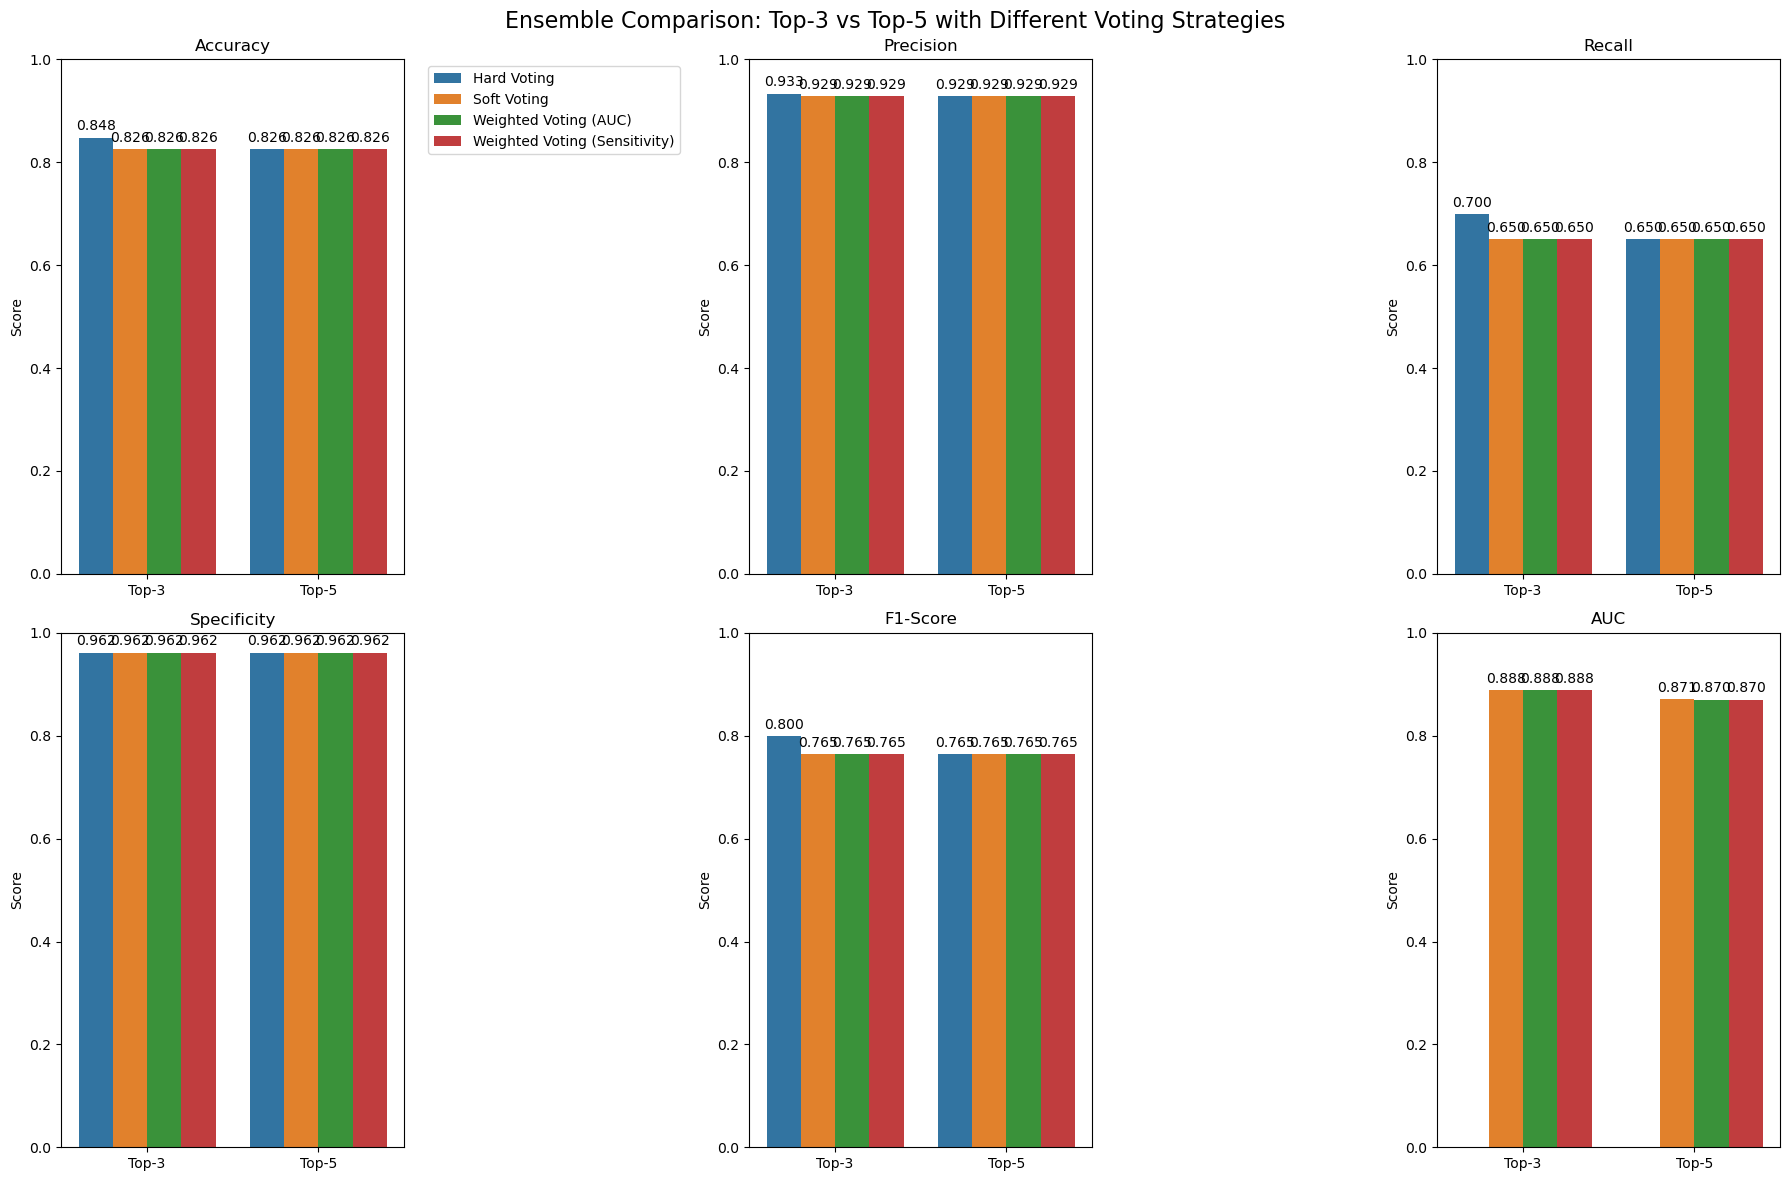

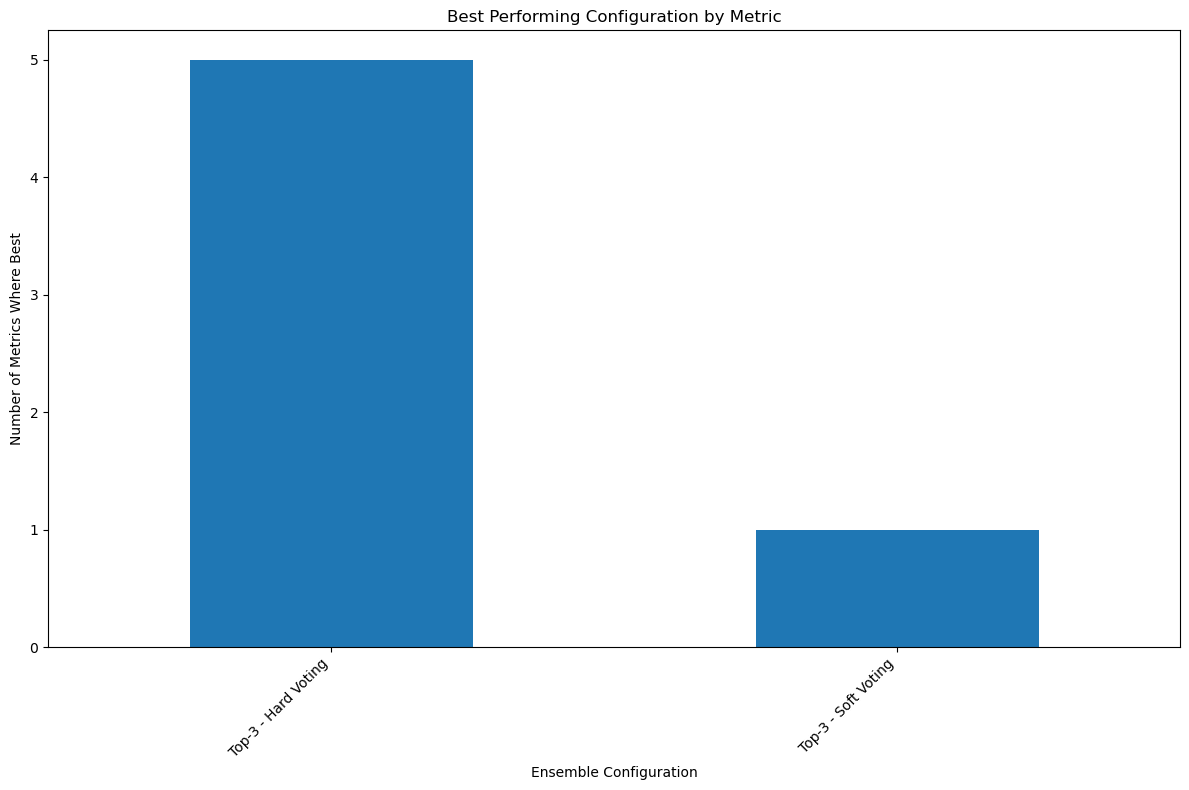

In [15]:
# Cell 11: Visualize Comparison Results
def plot_ensemble_comparison(comparison_df):
    """Create visualizations for ensemble comparison"""
    
    # Reshape data for plotting
    metrics_for_plot = comparison_df.melt(
        id_vars=['Model Set', 'Voting Strategy'],
        var_name='Metric',
        value_name='Score'
    )
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Ensemble Comparison: Top-3 vs Top-5 with Different Voting Strategies', fontsize=16)
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'AUC']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        
        metric_data = metrics_for_plot[metrics_for_plot['Metric'] == metric]
        
        # Create grouped bar plot
        sns.barplot(data=metric_data, x='Model Set', y='Score', hue='Voting Strategy', ax=ax)
        
        ax.set_title(metric)
        ax.set_ylim(0, 1)
        ax.set_xlabel('')
        ax.set_ylabel('Score')
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3)
        
        # Adjust legend
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            ax.get_legend().remove()
    
    plt.tight_layout()
    plt.show()
    
    # Create separate plot for best performers
    plt.figure(figsize=(12, 8))
    
    best_by_metric = {}
    for metric in metrics:
        best_idx = comparison_df[metric].idxmax()
        best_row = comparison_df.iloc[best_idx]
        best_by_metric[metric] = f"{best_row['Model Set']} - {best_row['Voting Strategy']}"
    
    best_performers = pd.Series(best_by_metric)
    best_performers.value_counts().plot(kind='bar')
    plt.title('Best Performing Configuration by Metric')
    plt.xlabel('Ensemble Configuration')
    plt.ylabel('Number of Metrics Where Best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_ensemble_comparison(comparison_df)


In [16]:
# Cell 12: Statistical Comparison
def statistical_analysis(comparison_df):
    """Perform statistical analysis of ensemble strategies"""
    
    # Find best configuration for each metric
    print("\nBest Configuration for Each Metric:")
    print("-" * 50)
    for metric in ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'AUC']:
        best_idx = comparison_df[metric].idxmax()
        best_row = comparison_df.iloc[best_idx]
        print(f"{metric}: {best_row['Model Set']} with {best_row['Voting Strategy']} = {best_row[metric]:.4f}")
    
    # Summary statistics
    print("\nSummary Statistics by Model Set:")
    print("-" * 50)
    summary = comparison_df.groupby('Model Set').agg({
        'Accuracy': ['mean', 'std', 'max', 'min'],
        'AUC': ['mean', 'std', 'max', 'min']
    }).round(4)
    print(summary)
    
    print("\nSummary Statistics by Voting Strategy:")
    print("-" * 50)
    summary = comparison_df.groupby('Voting Strategy').agg({
        'Accuracy': ['mean', 'std', 'max', 'min'],
        'AUC': ['mean', 'std', 'max', 'min']
    }).round(4)
    print(summary)
    
    # Performance gain analysis
    print("\nPerformance Gain Analysis:")
    print("-" * 50)
    baseline = comparison_df[(comparison_df['Model Set'] == 'Top-3') & 
                           (comparison_df['Voting Strategy'] == 'Hard Voting')].iloc[0]
    
    for idx, row in comparison_df.iterrows():
        if idx == 0:  # Skip baseline
            continue
        gain = {
            'Configuration': f"{row['Model Set']} - {row['Voting Strategy']}",
            'Accuracy Gain': row['Accuracy'] - baseline['Accuracy'],
            'AUC Gain': row['AUC'] - baseline['AUC'],
            'F1 Gain': row['F1-Score'] - baseline['F1-Score']
        }
        print(f"{gain['Configuration']}:")
        print(f"  Accuracy: {gain['Accuracy Gain']:+.4f}")
        print(f"  AUC: {gain['AUC Gain']:+.4f}")
        print(f"  F1-Score: {gain['F1 Gain']:+.4f}")
        print()

statistical_analysis(comparison_df)


Best Configuration for Each Metric:
--------------------------------------------------
Accuracy: Top-3 with Hard Voting = 0.8478
Precision: Top-3 with Hard Voting = 0.9333
Recall: Top-3 with Hard Voting = 0.7000
Specificity: Top-3 with Hard Voting = 0.9615
F1-Score: Top-3 with Hard Voting = 0.8000
AUC: Top-3 with Soft Voting = 0.8885

Summary Statistics by Model Set:
--------------------------------------------------
          Accuracy                                 AUC                    \
              mean      std      max      min     mean      std      max   
Model Set                                                                  
Top-3     0.831500 0.010900 0.847800 0.826100 0.888500 0.000000 0.888500   
Top-5     0.826100 0.000000 0.826100 0.826100 0.870500 0.000600 0.871200   

                    
               min  
Model Set           
Top-3     0.888500  
Top-5     0.870200  

Summary Statistics by Voting Strategy:
--------------------------------------------------
 

In [17]:
# Cell 4.9 — Run-by-run metrics & IQR check (ensemble + optional base models)

import pandas as pd
import numpy as np

# --- 1) Build run-by-run metrics table from your existing `ensemble_results` ---

def ensemble_runs_to_dataframe(ensemble_results):
    """Convert `ensemble_results` (list of dicts) to a tidy per-run metrics DataFrame."""
    rows = []
    for r in ensemble_results:
        m = r['metrics']
        rows.append({
            'Run': r['run_number'],
            'ACC': m.get('accuracy', np.nan),
            'PRE': m.get('precision', np.nan),
            'SEN': m.get('recall', np.nan),
            'SPE': m.get('specificity', np.nan),
            'F1S': m.get('f1_score', np.nan),
            'AUC': m.get('auc', np.nan)  # will be NaN for hard voting
        })
    df = pd.DataFrame(rows).sort_values('Run', kind='stable').reset_index(drop=True)
    return df

def summarize_variation(df_runs):
    """Return Median, IQR, and n_unique per metric across runs + determinism check on predictions."""
    metrics = ['ACC','PRE','SEN','SPE','F1S','AUC']
    present = [m for m in metrics if m in df_runs.columns]
    X = df_runs[present]

    med = X.median()
    q1  = X.quantile(0.25)
    q3  = X.quantile(0.75)
    iqr = q3 - q1
    nunique = X.nunique()

    summary = (
        pd.DataFrame({'Median': med, 'IQR': iqr, 'n_unique': nunique})
        .round(6)
        .reset_index()
        .rename(columns={'index':'Metric'})
    )

    # All metrics identical across runs?
    all_metrics_identical = nunique.eq(1).all()

    return summary, bool(all_metrics_identical)

def count_unique_prediction_vectors(ensemble_results):
    """
    Check how many distinct 0/1 prediction vectors the ensemble produced across runs.
    If =1, predictions are identical every run (deterministic).
    """
    preds = np.vstack([r['predictions'] for r in ensemble_results])  # shape: (R, 46)
    unique_pred_rows = np.unique(preds, axis=0).shape[0]
    return int(unique_pred_rows)

# Build per-run table
ens_runs_df = ensemble_runs_to_dataframe(ensemble_results)

# Summarize Median / IQR / n_unique
summary_df, all_same = summarize_variation(ens_runs_df)

# Determinism check based on full prediction vectors
n_unique_pred_vectors = count_unique_prediction_vectors(ensemble_results)

# Display
display(
    ens_runs_df.style
    .set_caption(f"Run-by-Run Metrics — Ensemble ({voting_method}): " + ", ".join(models_to_use))
    .set_properties(**{'text-align': 'center'})
)
print("\nSummary across runs (Median / IQR / n_unique):")
print(summary_df.to_string(index=False))

print(f"\nAll metrics identical across runs? -> {all_same}")
print(f"Number of unique prediction vectors across runs -> {n_unique_pred_vectors}")

# Optional: save to CSV
ens_runs_df.to_csv("ensemble_run_by_run_metrics.csv", index=False)
summary_df.to_csv("ensemble_run_by_run_summary.csv", index=False)
print("\nSaved CSVs: ensemble_run_by_run_metrics.csv, ensemble_run_by_run_summary.csv")

# --- 2) (Optional) Per-base-model run-by-run metrics from df_models -----------------

def model_run_by_run_metrics(df_models, model_name, true_labels, threshold=0.5, sort_by='tag'):
    """
    Compute run-by-run metrics for a single base model using your stored predictions in df_models.
    Uses your helpers: parse_predictions + calculate_metrics.
    """
    sub = df_models[df_models['model_name'] == model_name].copy()
    if sub.empty:
        raise ValueError(f"No rows for model_name='{model_name}'. "
                         f"Available: {sorted(df_models['model_name'].unique().tolist())}")
    if sort_by in sub.columns:
        sub = sub.sort_values(sort_by, kind='stable')

    rows = []
    for i, (_, row) in enumerate(sub.iterrows(), start=1):
        probs = parse_predictions(row['predicts'])
        if probs is None:
            continue
        probs = np.asarray(probs[:len(true_labels)], dtype=float)
        y_pred = (probs >= threshold).astype(int)  # hard 0.5 threshold

        m = calculate_metrics(true_labels, y_pred, y_prob=probs)

        rows.append({
            'Run': i if 'tag' not in sub.columns else row.get('tag', i),
            'ACC': m.get('accuracy', np.nan),
            'PRE': m.get('precision', np.nan),
            'SEN': m.get('recall', np.nan),
            'SPE': m.get('specificity', np.nan),
            'F1S': m.get('f1_score', np.nan),
            'AUC': m.get('auc', np.nan)
        })

    out = pd.DataFrame(rows).sort_values('Run', kind='stable').reset_index(drop=True)
    return out

# Example usage (uncomment to inspect a base model):
# base_df = model_run_by_run_metrics(df_models, 'InceptionResNetV2', true_labels)
# display(base_df.style.set_caption("Run-by-Run Metrics — InceptionResNetV2"))
# base_summary, base_all_same = summarize_variation(base_df)
# print("\nBase model summary:")
# print(base_summary.to_string(index=False))
# print("\nAll metrics identical across runs? ->", base_all_same)


,Run,ACC,PRE,SEN,SPE,F1S,AUC
0,1,0.847826,0.933333,0.700000,0.961538,0.800000,nan
1,2,0.847826,0.933333,0.700000,0.961538,0.800000,nan
2,3,0.847826,0.933333,0.700000,0.961538,0.800000,nan
3,4,0.826087,0.928571,0.650000,0.961538,0.764706,nan
4,5,0.869565,0.850000,0.850000,0.884615,0.850000,nan
5,6,0.826087,0.928571,0.650000,0.961538,0.764706,nan
6,7,0.847826,0.933333,0.700000,0.961538,0.800000,nan
7,8,0.869565,0.937500,0.750000,0.961538,0.833333,nan
8,9,0.826087,0.928571,0.650000,0.961538,0.764706,nan
9,10,0.891304,0.941176,0.800000,0.961538,0.864865,nan



Summary across runs (Median / IQR / n_unique):
Metric   Median      IQR  n_unique
   ACC 0.847826 0.021739         4
   PRE 0.933333 0.004762         7
   SEN 0.700000 0.050000         5
   SPE 0.961538 0.000000         3
   F1S 0.800000 0.035294         7
   AUC      NaN      NaN         0

All metrics identical across runs? -> False
Number of unique prediction vectors across runs -> 9

Saved CSVs: ensemble_run_by_run_metrics.csv, ensemble_run_by_run_summary.csv
